# Stroke Predicition Analysis 🧠🤖🔍

Author: Sam Cooley

<div style="display: flex; justify-content: space-between;">
    <img src="https://www.health.com/thmb/lC47x-4eMcHPhTldVRTaVxdRE7U=/4000x0/filters:no_upscale():max_bytes(150000):strip_icc()/Health-stroke-overview-7254292-final-009786fc606c4dd6bb746c2bf8f8e1b0.png" alt="Stroke Overview Left" width="400"/>
    <img src="https://media.istockphoto.com/id/1200735930/vector/mental-health-concept.jpg?s=612x612&w=0&k=20&c=2cBGH6S8y7FzXiLLkWkQ5GHMhcZOMJWcuwQAhxZwo44=" alt="Stroke Overview Right" width="400"/>
</div>

## Background:

In this project, I build a classification model to predict a patient’s likelihood of having a stroke based on their health data. The dataset, sourced from Kaggle, is synthetic (i.e., not actual EHR data). I evaluate three different classification models: Logistic Regression, Random Forest, and XGBoost.

While the data itself is artificial, the goal of this project is to demonstrate how machine learning can be applied in a real healthcare setting. If deployed using actual Electronic Health Record (EHR) data, a similar model could help doctors assess a patient’s stroke risk. This information could then support both patients and healthcare providers in making informed decisions—whether that means taking preventive steps or planning ahead for potential medical care.


### (0) - Import Necessary Packages & Import Data 📥 💾

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


path = '/Users/samuelcooley/Library/CloudStorage/GoogleDrive-sam.a.cooley@gmail.com/My Drive/Knowledge Base/Projects/Stroke Prediction/'

raw_df = pd.read_csv(path + 'healthcare-dataset-stroke-data.csv')

### (1) - Exploratory Data Analysis 📊🤔

##### A.) Summary

In [2]:
print(f"Number of Rows: {raw_df.shape[0]}")
print(f"Number of Columns: {raw_df.shape[1]}")
print()
print(f"Columns:\n{raw_df.columns.tolist()}")
print()
print(f"Data Types:\n{raw_df.dtypes}")

Number of Rows: 5110
Number of Columns: 12

Columns:
['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Data Types:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [3]:
print()
print(f"Summary Statistics:\n{raw_df.describe()}")
print()
print(f"Missing Values:\n{raw_df.isna().sum()}") 


Summary Statistics:
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.0900

*Key findings*:
- The ‘bmi’ field contains missing values. In the data wrangling phase of this program, we will interpret these missing values and determine appropriate methods for handling them.
- The columns appear to be of the correct data type (e.g., we do not observe categorical variables such as ‘work_type’ being coded as floats or integers).
- The high standard deviation of 45.3 for ‘avg_glucose_level’ necessitates a thorough examination of the distribution

In [4]:
print(f"ID is unique: {raw_df.id.nunique() == raw_df.shape[0]}")
print(f"Number of Total Duplicates: {raw_df.duplicated().sum()}")

ID is unique: True
Number of Total Duplicates: 0


- The unique id field indicates patient-level data. While not used for analysis here, patient id variables like MRN, encounter, and claim id help identify patients, encounters, or care episodes and indicate data or observational unit levels.

##### B.) Review Columns by Type

###### (B.1) Review Categorical variables


In [5]:
str_cols = raw_df.select_dtypes(include=['object']).columns.tolist()

for col in str_cols:
    print(f"\nValues of {col}:\n{raw_df[col].value_counts(dropna=False)}") 


Values of gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Values of ever_married:
Yes    3353
No     1757
Name: ever_married, dtype: int64

Values of work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Values of Residence_type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

Values of smoking_status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


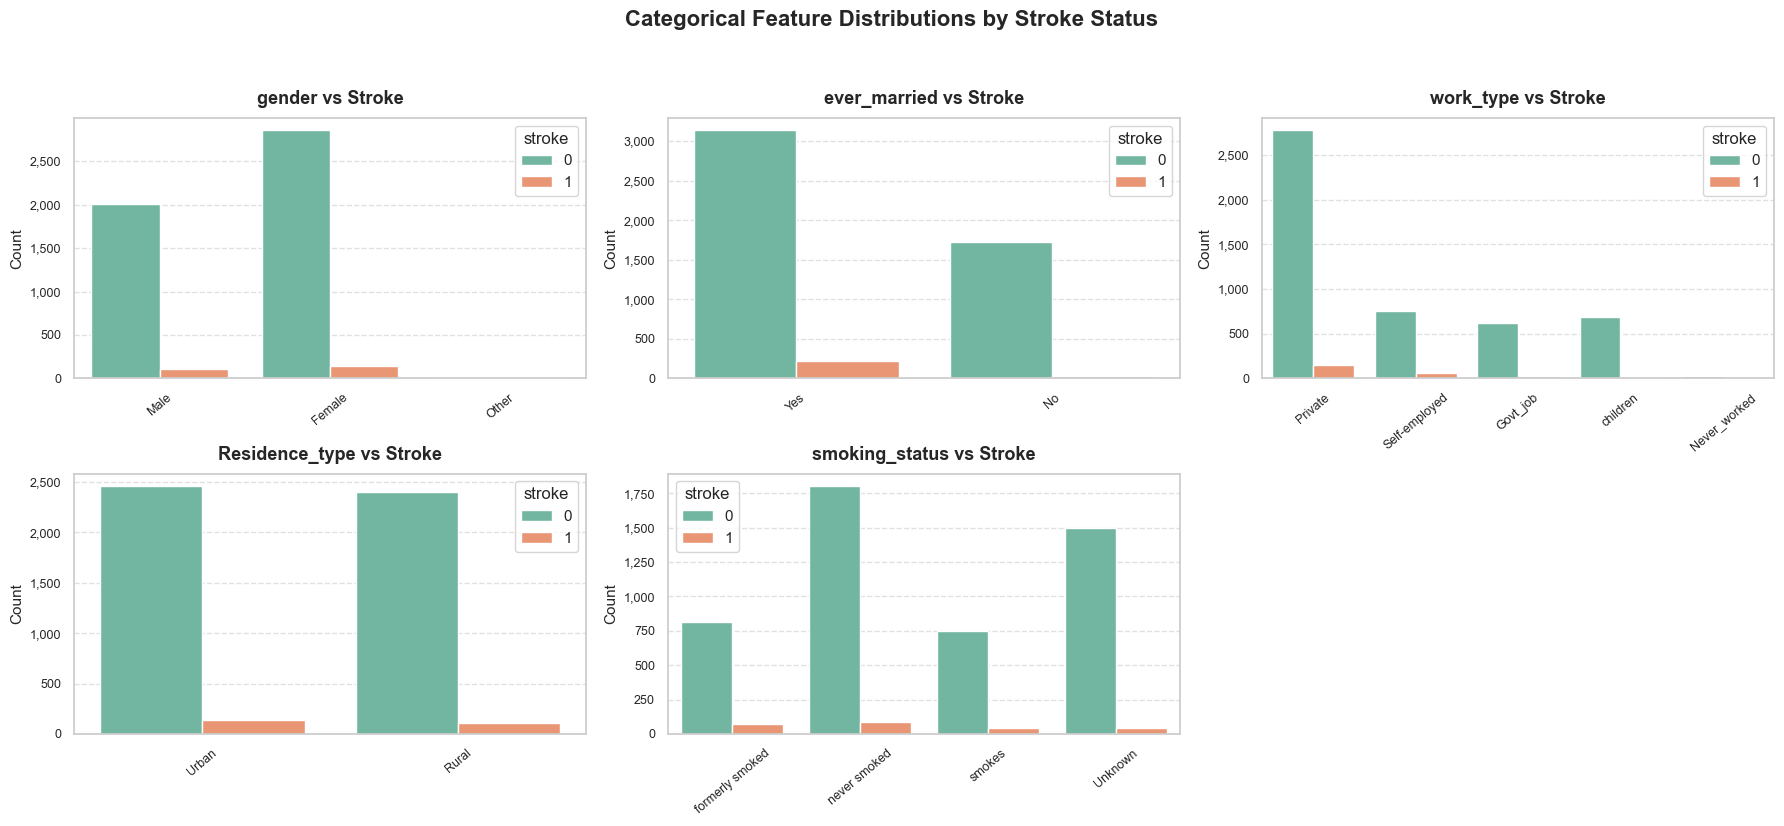

In [45]:
# Visualize categorical vars with respect to the stroke indicator 


sns.set_theme(style="whitegrid", palette="Set2")

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    
    if i < len(str_cols):
        col = str_cols[i]
        
        sns.countplot(data=raw_df, x=col, hue="stroke", ax=ax)
        
        ax.set_title(f"{col} vs Stroke", fontsize=13, weight="bold", pad=10)
        ax.set_xlabel("")
        ax.set_ylabel("Count", fontsize=11)
        
        ax.tick_params(axis='x', rotation=40, labelsize=9)
        ax.tick_params(axis='y', labelsize=9)
        
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
        
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        
    #remove unused axis
    else:
        ax.remove()

fig.suptitle("Categorical Feature Distributions by Stroke Status", fontsize=16, weight="bold", y=1.03)
fig.tight_layout()
plt.show()

###### (B.2) Review Numerical Variables

In [54]:
# Create a loop to iterate through each numeric column and create a box plot for outlier detection

def fn_make_plot(data, plot_type, title = None):
    
    
    numerics = data.drop(columns=['id']).select_dtypes(include=['float', 'int64']).columns
    
    
    n = len(numerics)
    rows = (n + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(18, 4 * rows))
    axes = axes.flatten()
    

    for i, ax in enumerate(axes):
        
        if i < n:
            col = numerics[i]

            plot_func = getattr(data, plot_type)
            plot_func(column=col, ax=ax)

            ax.set_title(col, fontsize=13, weight="bold", pad=10)
            
            ax.xaxis.set_label_text("")
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
            
            ax.tick_params(axis='x', labelsize=9)
            ax.tick_params(axis='y', labelsize=9)
            
            ax.grid(axis="y", linestyle="--", alpha=0.6)
            
        #remove unused axis
        else:
            ax.remove()
            
    if title:
        fig.suptitle(title, fontsize=16, weight="bold", y=1.02)    

    fig.tight_layout()
    plt.show()

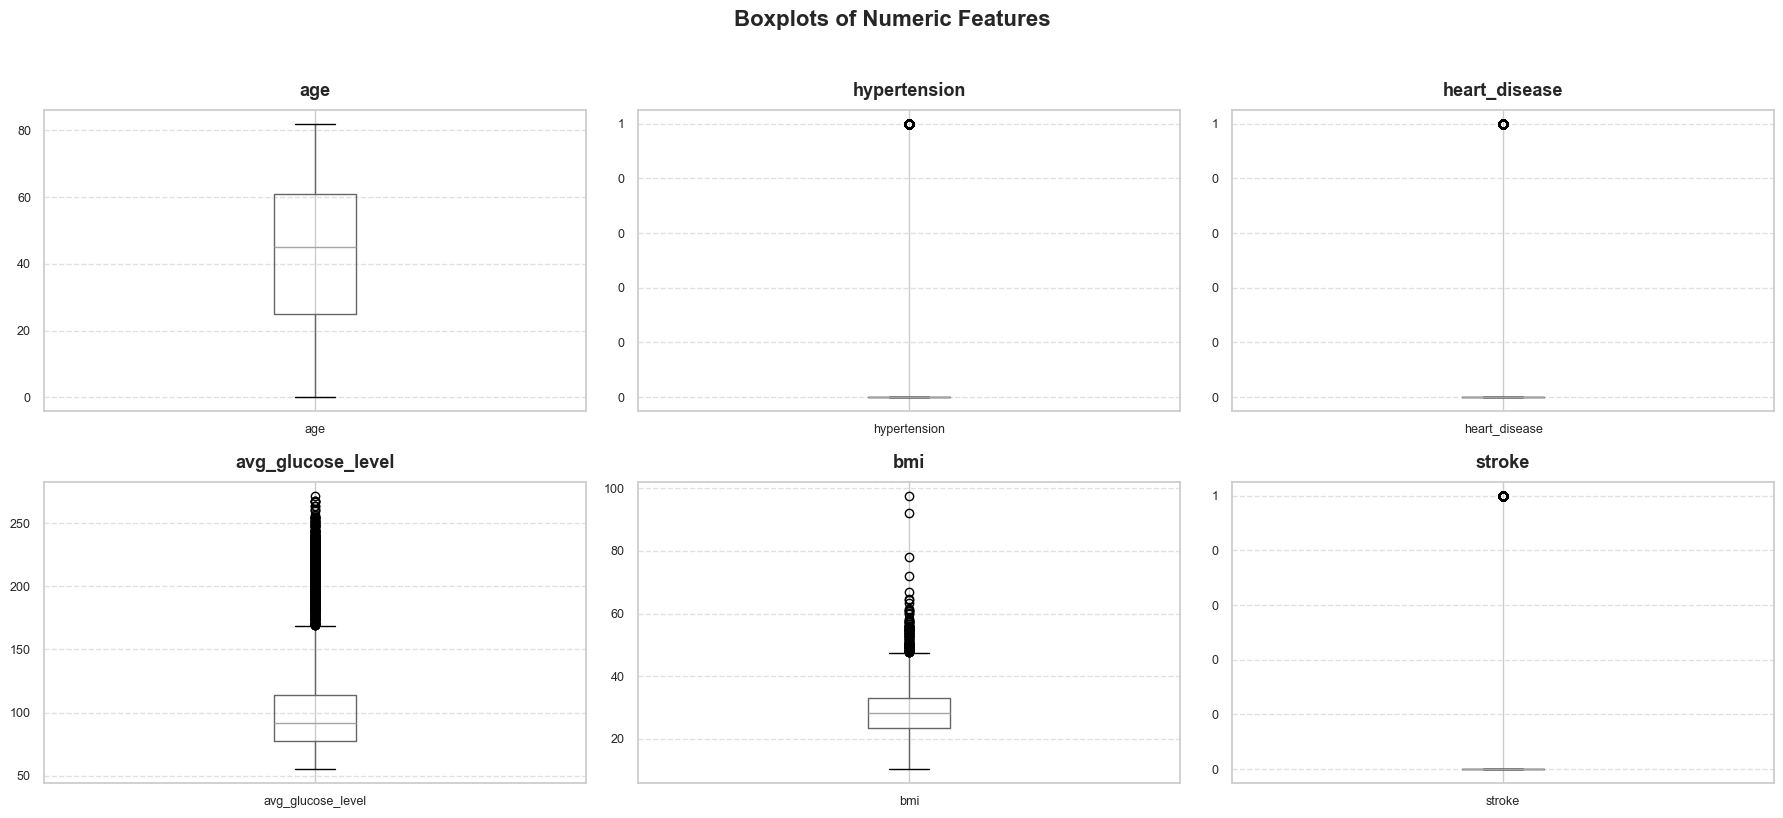

In [57]:
# Boxplots    
fn_make_plot(raw_df, "boxplot", title="Boxplots of Numeric Features")  

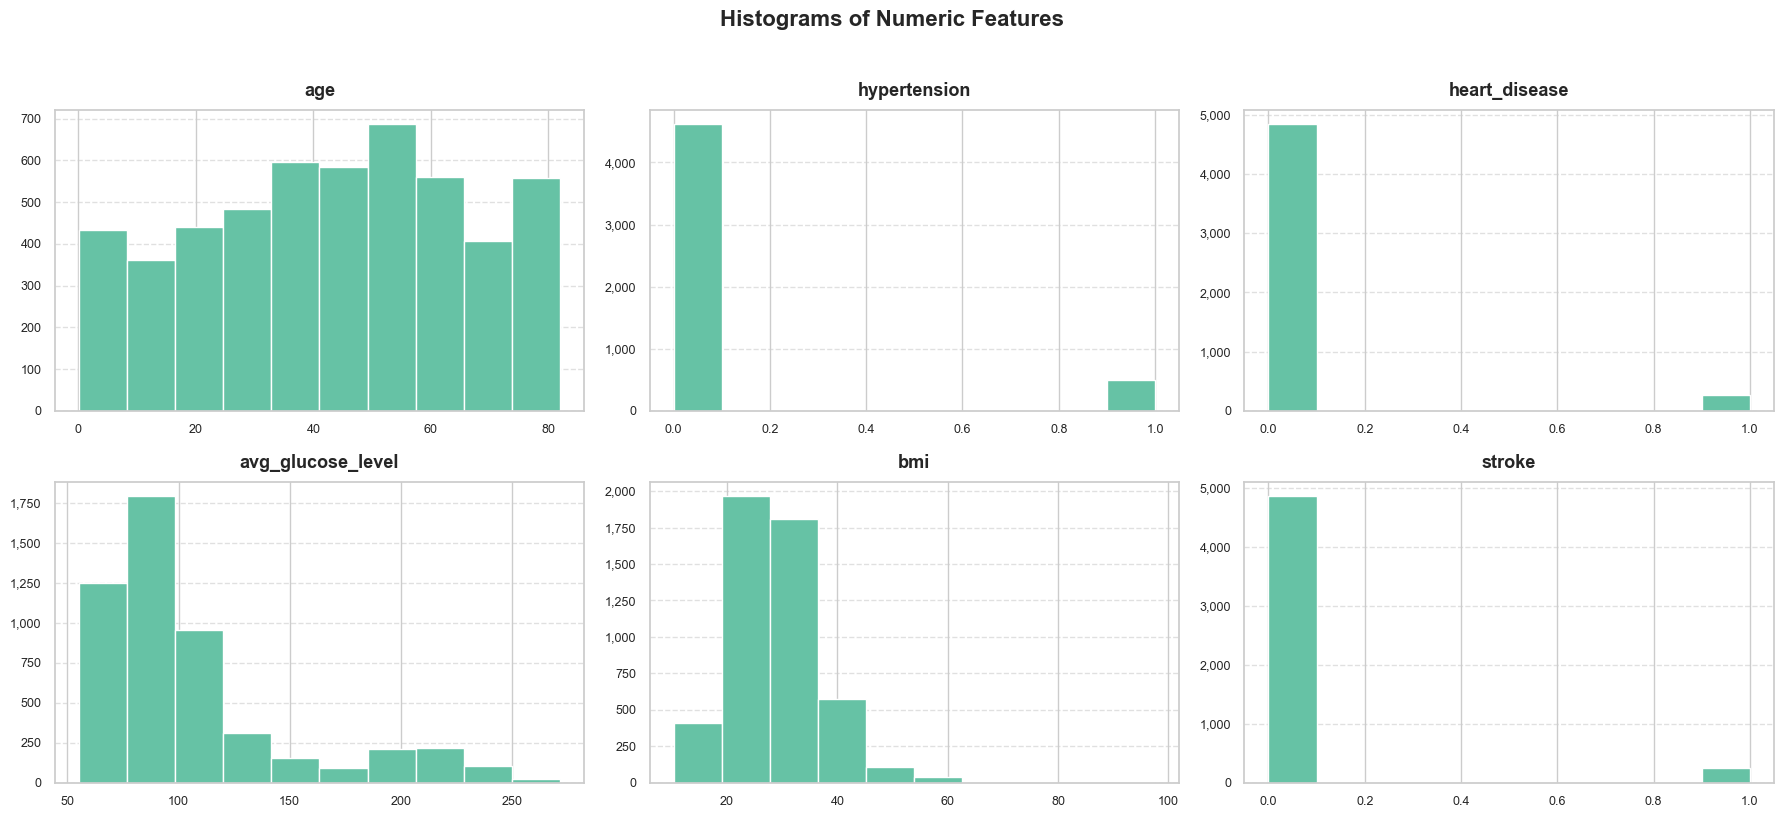

In [58]:
# Histograms
fn_make_plot(raw_df, "hist", title="Histograms of Numeric Features")   

*Key Findings:*
- There are clear outliers in both average glucose level and BMI, but they seem to reflect real-world variability rather than data entry errors. Given known trends in obesity and metabolic health, these extreme values are plausible. However, these outliers should not be dismissed without further investigation. The average glucose level and Body Mass Index (BMI) both exhibit right-skewed distributions, primarily due to outliers well above the mean.


- The dataset also includes newborns (age = 0) and appears skewed toward older patients, which makes sense—stroke risk increases with age. A quick way to validate this assumption is by checking the correlation between age and stroke occurrence. While correlation doesn’t imply causation, it helps confirm whether the data aligns with expected medical trends.

##### C.) Correlation Matrix

In [10]:
df = raw_df.copy()

df.drop(columns=['id'], inplace=True)

#temporary dataframe for matrix (to include numeric columns only)
num_df = df.select_dtypes(include=["number"])
corr_matrix = num_df.corr()
stroke_corr = corr_matrix['stroke'].sort_values(ascending = False)


print(stroke_corr)

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64


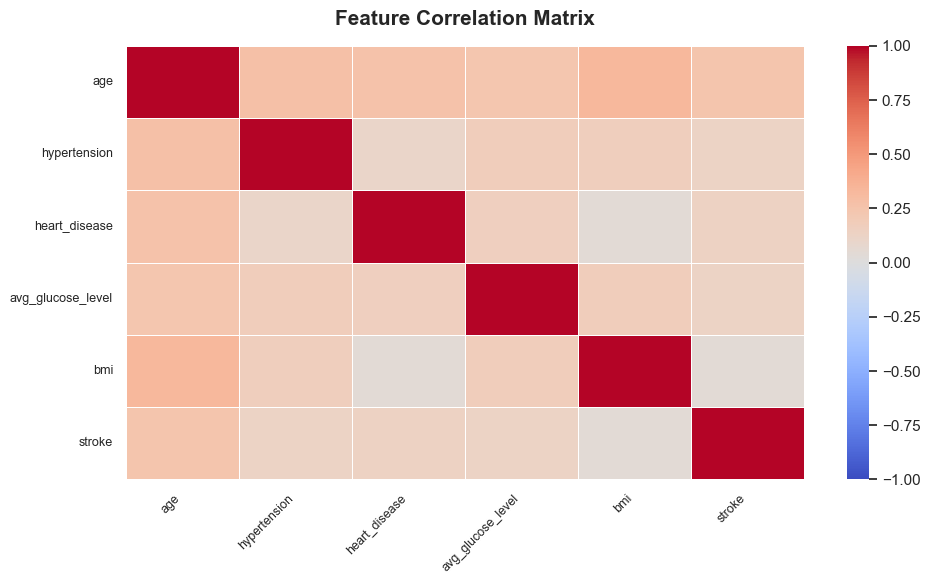

In [11]:
#Plot the correlation matrix: 


sns.set_theme(style="whitegrid", palette="Set2")
plt.figure(figsize=(10, 6))


sns.heatmap(
    corr_matrix,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title("Feature Correlation Matrix", fontsize=15, weight="bold", pad=15)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


- The correlations with stroke occurrence are generally weak, with the exception of age, which shows a notable positive relationship. This supports our expectation that as age increases, the likelihood of stroke also rises. While this doesn’t establish causation, it aligns with well-documented medical patterns and reinforces our initial assumption.

For robustness, let’s examine the correlation between age and the other features to identify potential interactions and underlying relationships:


In [12]:
age_corr = corr_matrix['age'].sort_values(ascending = False)
print(age_corr)

age                  1.000000
bmi                  0.333398
hypertension         0.276398
heart_disease        0.263796
stroke               0.245257
avg_glucose_level    0.238171
Name: age, dtype: float64


- As expected, age shows a moderately strong correlation with key biological factors such as BMI, hyper tension, heart disease, and stroke, aligning with known medical trends.

- None of the features show strong enough correlations to raise concerns about multicollinearity. This matters only for our logistic regression model, so no additional steps were needed (e.g., dropping features or creating interaction variables).


### (2) - Data Cleaning 🧹

##### A.) Handle Missing Values

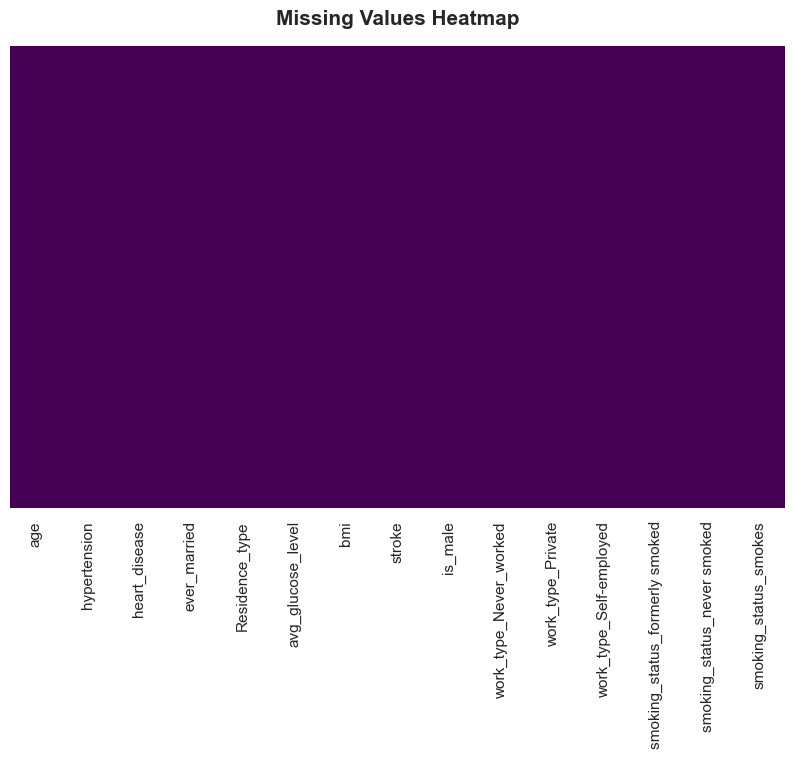

In [37]:
#Visualize Missing values 

sns.set_theme(style="whitegrid", palette="Set2")
plt.figure(figsize=(10, 6))

sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap",fontsize=15, weight="bold", pad=15)
plt.show()

In [14]:
# Check if BMI missingness is related to other features
df_missing_bmi = df.copy()
df_missing_bmi['bmi_missing'] = df_missing_bmi['bmi'].isnull().astype(int)
print(f"Total number of missing BMI values: {df_missing_bmi['bmi_missing'].sum()}")
print(f"Percent of missing BMI from data: {round((df_missing_bmi['bmi_missing'].sum()/len(df)) * 100, 2)}%")

Total number of missing BMI values: 201
Percent of missing BMI from data: 3.93%


In [15]:
# Correlation of missing BMI with other features
missing_bmi_corr = df_missing_bmi.drop(columns=['bmi']).corr()['bmi_missing'].drop('bmi_missing')
print(missing_bmi_corr)

age                  0.078956
hypertension         0.093046
heart_disease        0.098621
avg_glucose_level    0.091957
stroke               0.141238
Name: bmi_missing, dtype: float64


- There are 201 missing BMI values in the dataset, accounting for about 4% of all BMI observations. Since BMI missingness is weakly correlated with other features, we can assume it’s Missing at Random (MAR) rather than systematically related to other variables. Given outliers and a right-skewed BMI distribution, replacing missing values with the median is a sound approach, as it’s less affected by extreme values.

- Before we impute the missing values, however, we should first filter outliers from our data so that we can calculate a median value that excludes outliers.


##### B.) Outliers

- We’ll first quantify the number of outliers in BMI and average glucose level features before deciding whether to remove or impute them

In [16]:
def flag_outliers(df, cols):
    
    '''
    Calculates Interquartile Range
    Returns: Flag an observation that is an outlier
    '''
       
    #initialize empty dictionary for concatenation      
    outlier_flags = {} 
    
    for col in cols:
        
        #calculate interquartile range (IQR)
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        outlier_flags[f"flag_outlier_{col}"] = (df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr))
        
    df_flags = pd.DataFrame(outlier_flags)
    df = pd.concat([df, df_flags], axis=1)    
     
        
    return df

df_outliers = flag_outliers(df, ['bmi', 'avg_glucose_level']) 


print(f"Percent of BMI Outliers: {round(len(df_outliers.query('flag_outlier_bmi == True'))/len(df_outliers)*100, 2)}%")

print(f"Percent of Avg Glucose Outliers: {round(len(df_outliers.query('flag_outlier_avg_glucose_level == True'))/len(df_outliers)*100, 2)}%")

Percent of BMI Outliers: 2.15%
Percent of Avg Glucose Outliers: 12.27%


- Given the high number of outliers, particularly in average glucose levels, removing them would eliminate over 12% of the data, which is not ideal. Given the dataset’s imbalance and the likelihood that these outliers represent real individuals with high BMI and glucose due to obesity, they are unlikely to distort feature-target relationships. This is supported by the low correlation between glucose, BMI, and stroke.


In [17]:
#Fill in the missing values for BMI:
df.fillna(df['bmi'].median(), inplace = True)

print(f"Total number of missing BMI values: {df.bmi.isna().sum()}")


Total number of missing BMI values: 0


##### C.) Encoding

In [18]:
# We can combine 'children' & 'Never-worked' from work_type into the same category,
# assuming children haven’t worked. We'll also handle the 'Other' gender.

df = df.assign(work_type = lambda x: x['work_type'].replace({'children': 'Never_worked'}),
               is_male = lambda x : np.where(x['gender'] == 'Male', 1, 0)) \
        .drop(columns=['gender'])

# Identify binary vs. multi-class categorical variables
binary_cats = ['is_male', 'ever_married', 'Residence_type']
multi_cats = ['work_type', 'smoking_status']


# Encode binary categorical variables using Label Encoding
encoder = LabelEncoder()

for col in binary_cats:
    df[col] = encoder.fit_transform(df[col])

# Encode multi-class categorical variables using One-Hot Encoding
df = pd.get_dummies(df, columns=multi_cats, drop_first=True)   

### (3) - Model Preprocessing 🔄🧠

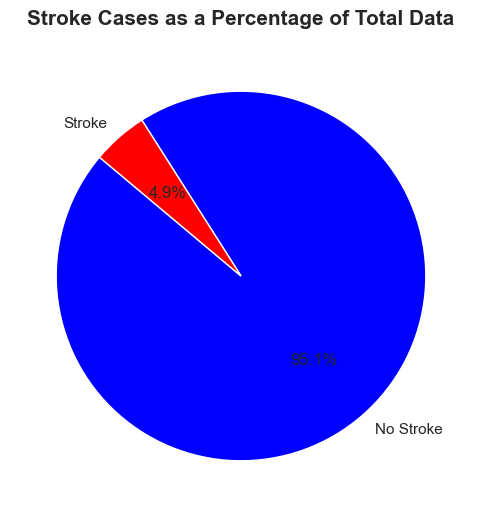

In [38]:
# A.) Split Features & Target

X = df.drop(columns=['stroke'])
y = df['stroke']


#A.1) check for class imbalance
stroke_pos = (y == 1).sum()/len(y) * 100
stroke_neg = (y == 0).sum()/len(y) * 100
labels = ['No Stroke', 'Stroke']
sizes = [stroke_neg, stroke_pos]


plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['blue', 'red'])
plt.title("Stroke Cases as a Percentage of Total Data", fontsize=15, weight="bold", pad=15)
plt.show()


# Handle imbalance using SMOTE (BEFORE splitting, otherwise test set will imbalanced.)
#does run the risk of dataleakage

smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

In [23]:
#B.)  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, stratify=y_sm, random_state=42)


# Standardize Numerical Features
scaler = StandardScaler()

num_cols = X_train.select_dtypes(include=['float', 'int64']).columns.tolist()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

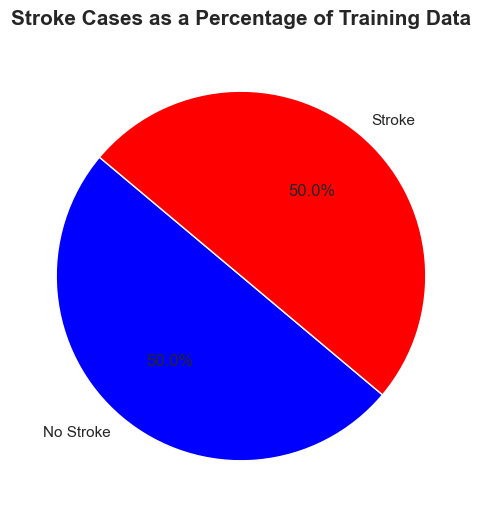

In [39]:
#Ensure class is now balanced
stroke_pos = (y_train == 1).sum()/len(y_train) * 100
stroke_neg = (y_train == 0).sum()/len(y_train) * 100
labels = ['No Stroke', 'Stroke']
sizes = [stroke_neg, stroke_pos]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['blue', 'red'])
plt.title("Stroke Cases as a Percentage of Training Data", fontsize=15, weight="bold", pad=15)
plt.show()

### (4) - Model Training & Evaluation 🤖📈

In [25]:
# Train Logistic Regression
lr = LogisticRegression(class_weight="balanced", random_state=42)
lr.fit(X_train, y_train)

# Train Random Forest Classifier 
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# Train XGBoost (with class weighting for imbalance)
xgb = XGBClassifier(scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1], 
                          random_state=42)
xgb.fit(X_train, y_train)


# Predictions
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)


# Evaluation - Logistic Regression
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Evaluation - Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Evaluation - XGBoost
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       973
           1       0.87      0.88      0.88       972

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       973
           1       0.95      0.97      0.96       972

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       973
           1       0.95      0.97      0.96       972

    accuracy                           0.96      1945
   macro avg  

### (5) - Visualizations 📈📊

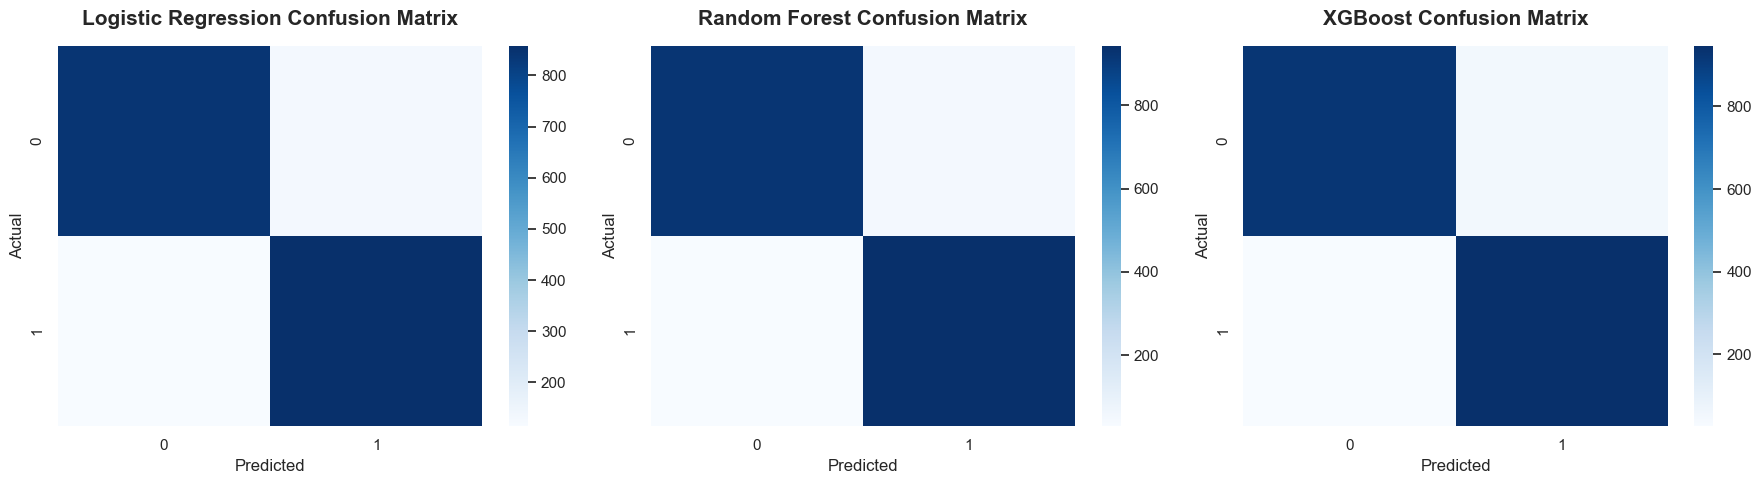

In [40]:
# Confusion Matrix Visualization

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Increased width for better spacing


models = ["Logistic Regression", "Random Forest", "XGBoost"]
predictions = [y_pred_lr, y_pred_rf, y_pred_xgb]

# Generate confusion matrices dynamically
for i, (model, pred) in enumerate(zip(models, predictions)):
    sns.heatmap(confusion_matrix(y_test, pred), annot=False, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{model} Confusion Matrix", fontsize=15, weight="bold", pad=15)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

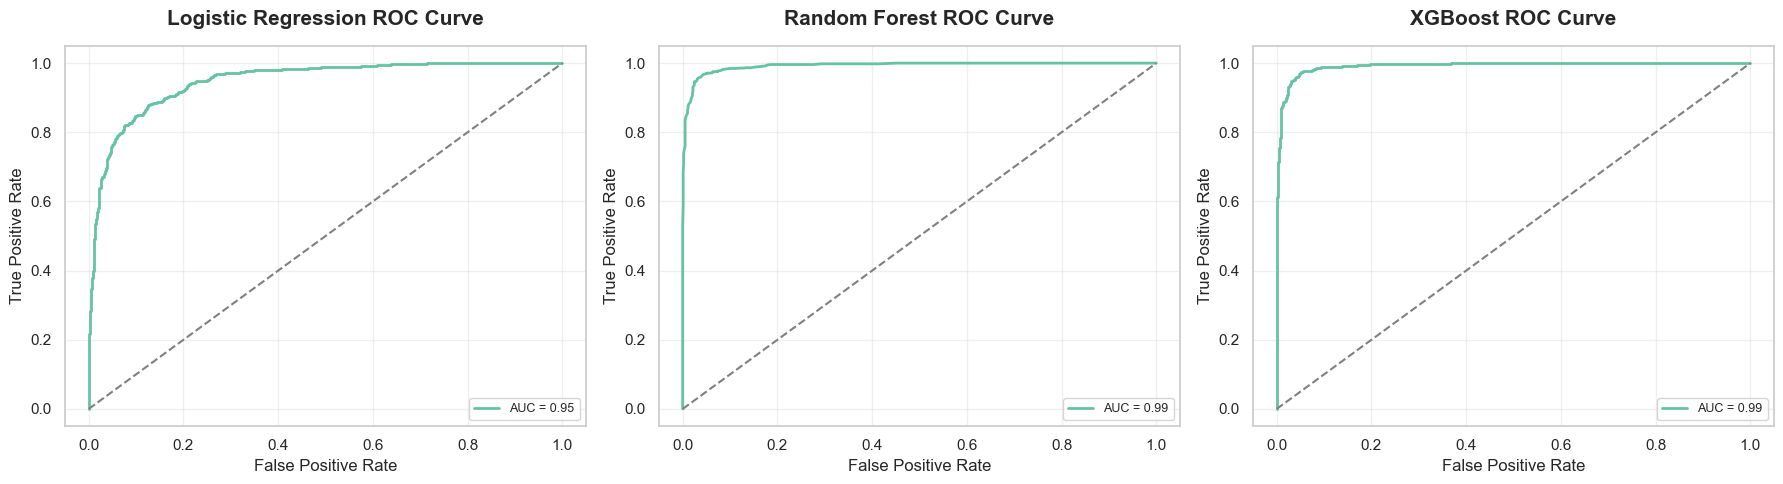

In [41]:
# ROC Curve Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Increased width for better spacing

# Define models, predictions, and probabilities
models = ["Logistic Regression", "Random Forest", "XGBoost"]
probs = [lr.predict_proba(X_test)[:, 1],
         rf.predict_proba(X_test)[:, 1],
         xgb.predict_proba(X_test)[:, 1]]

# Generate ROC curves dynamically
for i, (model, y_prob) in enumerate(zip(models, probs)):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    axes[i].plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", linewidth=2)
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[i].set_title(f"{model} ROC Curve", fontsize=15, weight="bold", pad=15)
    axes[i].set_xlabel("False Positive Rate")
    axes[i].set_ylabel("True Positive Rate")
    axes[i].legend(loc="lower right", fontsize=9)
    axes[i].grid(alpha=0.3)

plt.tight_layout()

## Conclusions: